In [1]:
import pandas as pd
import numpy as np 
from math import * 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 

STOCK_NAME = "msft"
equity_data = pd.read_csv(STOCK_NAME + " test data.csv")
rf_data = pd.read_csv("rf rate " + STOCK_NAME + ".csv")
data = equity_data.merge(rf_data, left_on='date', right_on='date')

data["log equity returns"] = np.log(1+data['RET'] - data['rf'])
data['spr log returns'] = np.log(1+data['sprtrn'] - data['rf'])

data['month'] = data['date'].str[:-3]
data['monthly avg trade'] = data.groupby('month')['NUMTRD'].transform('mean')
print(data)

      PERMNO        date       RET    NUMTRD    sprtrn       rf  \
0      10107  1990-01-02  0.020115     409.0  0.017799  0.00026   
1      10107  1990-01-03  0.005634     671.0 -0.002586  0.00026   
2      10107  1990-01-04  0.029412     614.0 -0.008613  0.00026   
3      10107  1990-01-05 -0.024490     533.0 -0.009756  0.00026   
4      10107  1990-01-08  0.015342     337.0  0.004514  0.00026   
...      ...         ...       ...       ...       ...      ...   
8310   10107  2022-12-23  0.002267  259590.0  0.005868  0.00016   
8311   10107  2022-12-27 -0.007414  229209.0 -0.004050  0.00016   
8312   10107  2022-12-28 -0.010255  217980.0 -0.012021  0.00016   
8313   10107  2022-12-29  0.027630  227261.0  0.017461  0.00016   
8314   10107  2022-12-30 -0.004938  246071.0 -0.002541  0.00016   

      log equity returns  spr log returns    month  monthly avg trade  
0               0.019660         0.017387  1990-01         546.454545  
1               0.005360        -0.002850  1990-01 

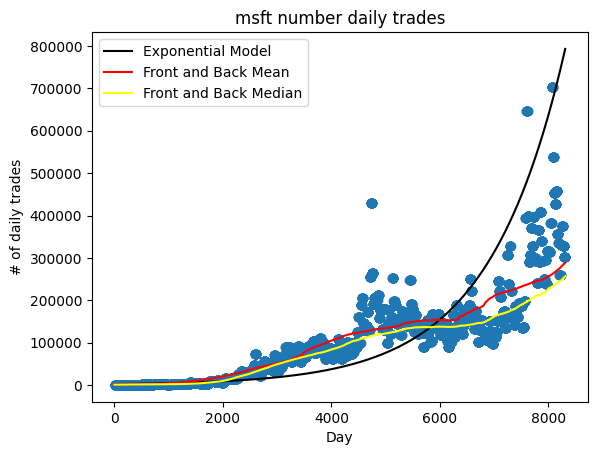

In [2]:
#some trading days had 0, 1, or NaN, either bugs or not they mess stuff up
data["NUMTRD"].fillna(value=0)
data = data[data["NUMTRD"] > 1]

#EXPONENTIAL REGRESSION 
y_data = data['monthly avg trade']
y_data_log = np.log(y_data)
x_data = np.arange(1, y_data.shape[0]+1, 1).reshape(-1,1)

lin_reg = LinearRegression()
lin_reg.fit(x_data, y_data_log)
          
# Generate points for plotting the linear regression line in log scale
y_model_log = lin_reg.predict(x_data)
y_model = np.exp(y_model_log)

plt.scatter(x_data, y_data)
plt.plot(x_data, y_model, color="black", zorder=2, label='Exponential Model')

plt.ylabel("# of daily trades")
plt.xlabel("Day")

# Modified function to take a Pandas Series (a single column from a DataFrame) as input
def calculate_average(series, window):
    # Extended series with NaNs for handling edge cases
    extended_series = pd.Series([np.nan] * window + series.tolist() + [np.nan] * window)
    
    # List to store the results
    averages = []

    for i in range(len(series)):
        # Calculate the window range
        start_index = i
        end_index = i + 2 * window + 1

        # Extract the window values, ignoring NaNs
        window_values = extended_series[start_index:end_index].dropna()

        # Calculate the average
        if len(window_values) > 0:
            avg = window_values.mean()
        else:
            avg = np.nan
        
        averages.append(avg)

    return averages

# Applying the function to a single column of the DataFrame
window_size = 1260  # Change this value as needed
data['trading moving average'] = calculate_average(data['NUMTRD'], window_size)
plt.plot(data[['trading moving average']], color='red', label='Front and Back Mean')

# Modified function for median smoothing
def median_smoothing(series, window):
    # Extended series with NaNs for handling edge cases
    extended_series = pd.Series([np.nan] * window + series.tolist() + [np.nan] * window)
    
    # List to store the results
    medians = []

    for i in range(len(series)):
        # Calculate the window range
        start_index = i
        end_index = i + 2 * window + 1

        # Extract the window values, ignoring NaNs
        window_values = extended_series[start_index:end_index].dropna()

        # Calculate the median
        if len(window_values) > 0:
            med = window_values.median()
        else:
            med = np.nan
        
        medians.append(med)

    return medians

# Applying the median smoothing function to the same large DataFrame
data['trading moving median'] = median_smoothing(data['NUMTRD'], window_size)
plt.plot(data[['trading moving median']], color='yellow', label='Front and Back Median')
plt.title(STOCK_NAME + " number daily trades")
plt.legend()

Exponential Model Ratio: 
1.3636339009256324
Moving Average Model Ratio: 
0.8625710229449046
Moving Median Model Ratio: 
1.1039271005892344


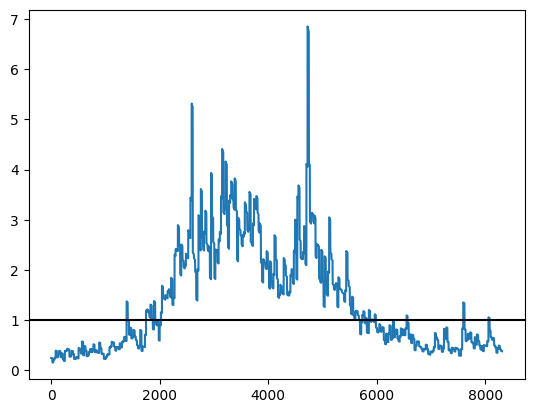

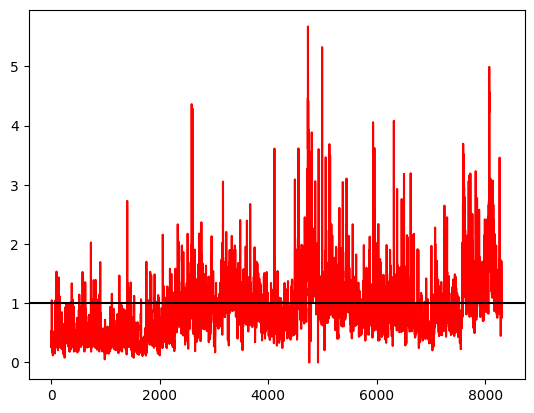

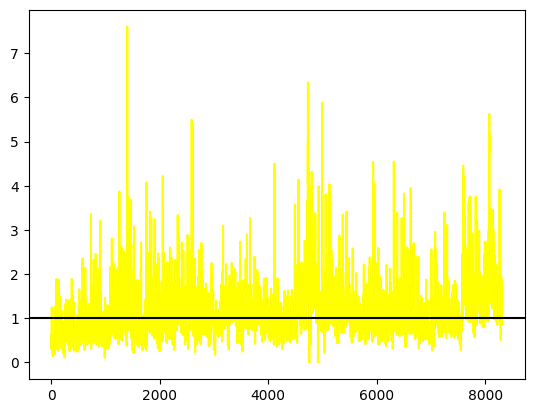

In [3]:
sum_trades = np.sum(y_data)
num_days = y_data.shape[0]

normalized_trading = (y_data / y_model).to_numpy()
print("Exponential Model Ratio: ")
print(np.sum(normalized_trading)/num_days)
plt.plot(normalized_trading)
plt.axhline(1, color="black")
#should we maybe just adjust it down by the ratio to finish it or fix the model? 

normalized_trading_2 = (data['NUMTRD'] / data['trading moving average']).to_numpy()
plt.figure()
plt.plot(normalized_trading_2, color='red')
plt.axhline(1, color="black")
print("Moving Average Model Ratio: ")
print(np.sum(normalized_trading_2) / num_days)

normalized_trading_3 = (data['NUMTRD'] / data['trading moving median']).to_numpy()
print("Moving Median Model Ratio: ")
print(np.sum(normalized_trading_3)/num_days)
plt.figure()
plt.plot(normalized_trading_3, color='yellow')
plt.axhline(1, color="black")

(array([  3.,  19.,  88., 114., 112.,  38.,  14.,   4.,   3.,   1.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <BarContainer object of 10 artists>)

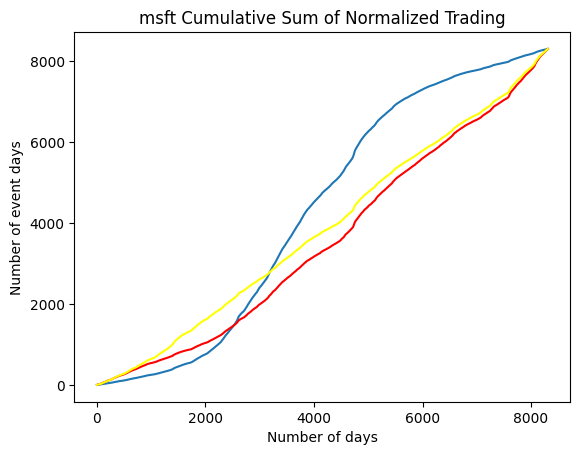

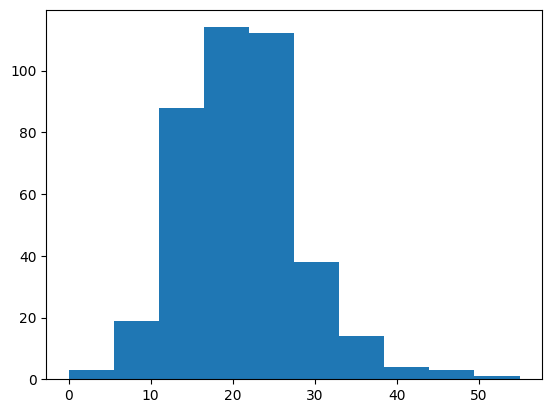

In [14]:
normalized_trading_scaled = normalized_trading * normalized_trading.shape[0]/np.sum(normalized_trading)
normalized_trading_scaled_2 = normalized_trading_2 * normalized_trading_2.shape[0]/np.sum(normalized_trading_2)
normalized_trading_scaled_3 = normalized_trading_3 * normalized_trading_3.shape[0]/np.sum(normalized_trading_3)

cum_sum = np.cumsum(normalized_trading_scaled)
plt.plot(cum_sum)
plt.plot(np.cumsum(normalized_trading_scaled_2), color='red')
plt.plot(np.cumsum(normalized_trading_scaled_3), color='yellow')

"""PICK WHICH ONE I WANT -> no comment, exponential, #2, average, #3, median"""
normalized_trading_scaled = normalized_trading_scaled_3 #median

num_events = len(data.groupby('month').sum())
normalized_days_per_month = np.sum(normalized_trading_scaled)/(num_events) #equal to days per month
new_blocks = np.empty(num_events, dtype=int)
counter__ = np.empty(num_events)
current_sum = 0 
counter = 0
othercounter = 0 
for i in range(normalized_trading_scaled.size):
    current_sum += normalized_trading_scaled[i]
    othercounter += 1
    if(current_sum > normalized_days_per_month):
        current_sum -= normalized_days_per_month 
        new_blocks[counter] = i
        counter += 1
        counter__[counter] = othercounter
        othercounter = 0
#last one is end 
new_blocks[-1] = normalized_trading_scaled.size-1
plt.ylabel("Number of event days")
plt.xlabel("Number of days")
plt.title(STOCK_NAME + " Cumulative Sum of Normalized Trading")
plt.figure()
plt.hist(counter__)

skew monthly: 
-0.1455042360002608
skew event month: 
0.07433346632510258
kurtosis monthly: 
2.419784216816492
kurtosis event month:
1.1734592726456636


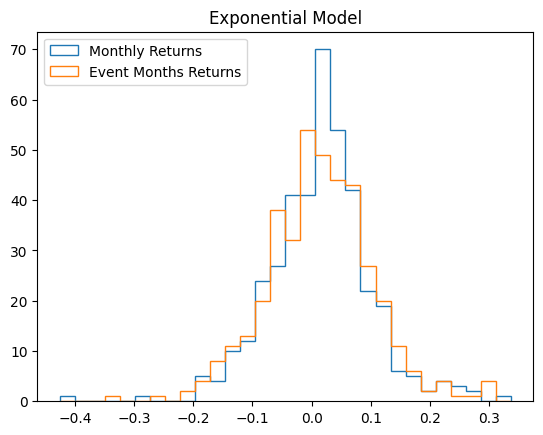

In [5]:
#calculate monthly returns 
equity_event_month_returns = np.zeros(num_events)
sp_event_month_returns = np.zeros(num_events)
counter = 0 
data["sprtrn"] += 1
for index, val in enumerate(data["log equity returns"].to_numpy()):
    equity_event_month_returns[counter] += val
    if index == new_blocks[counter]:
        counter += 1
counter = 0
for index, val in enumerate(data["spr log returns"].to_numpy()):
    sp_event_month_returns[counter] += (val)
    if index == new_blocks[counter]:
        counter += 1
        
equity_monthly_returns = data.groupby('month')["log equity returns"].sum().to_numpy()
sp_monthly_returns = data.groupby('month')["spr log returns"].sum().to_numpy()
_, bins, _, = plt.hist(equity_monthly_returns, bins=30, histtype=u'step', label="Monthly Returns")
plt.hist(equity_event_month_returns, bins=bins,  histtype=u'step', label="Event Months Returns")
plt.legend()
plt.title("Exponential Model")

import scipy.stats as scipystats

print("skew monthly: ")
print(scipystats.skew(equity_monthly_returns))
print("skew event month: ")
print(scipystats.skew(equity_event_month_returns))
print("kurtosis monthly: ")
print(scipystats.kurtosis(equity_monthly_returns))
print("kurtosis event month:")
print(scipystats.kurtosis(equity_event_month_returns))

r2 event month: 
0.46366792223469144
r2 monthly: 
0.3965148567801863
beta event month (might be wrong?)
0.9660947765367277
beta monthly (might be wrong?)
0.9812525484367882


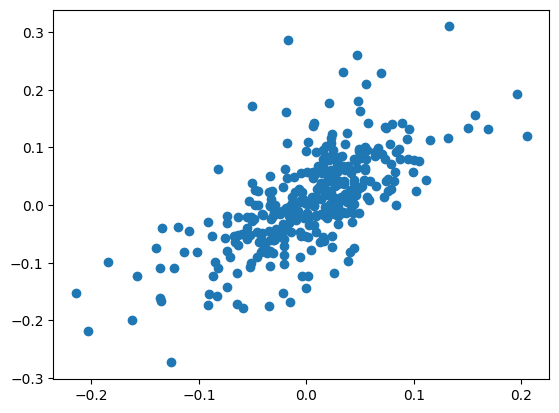

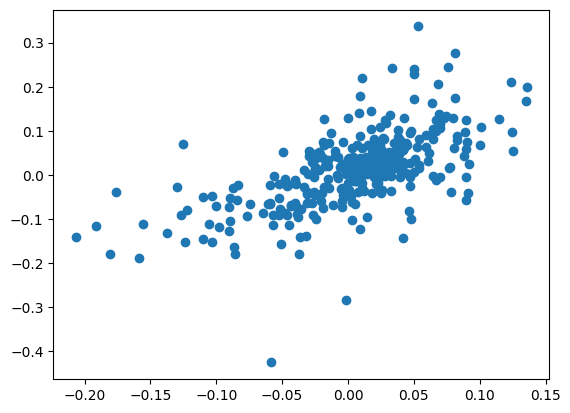

In [6]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import r2_score

capm_event_month = RollingOLS(pd.Series(equity_event_month_returns), pd.Series(sp_event_month_returns), 
                               window=60)

capm_monthly = RollingOLS(pd.Series(equity_monthly_returns), pd.Series(sp_monthly_returns), 
                               window=60)

event_month_betas = capm_event_month.fit(params_only=True).params.to_numpy().reshape(1, -1)[0]
monthly_betas = capm_monthly.fit(params_only=True).params.to_numpy().reshape(1, -1)[0]

"""actual_event_month_returns = equity_event_month_returns[61:] #need to check this
actual_monthly_returns = equity_monthly_returns[61:] #need to check this 
expected_event_month_returns = np.multiply(event_month_betas[1:],sp_event_month_returns[:-1])
expected_monthly_returns = np.multiply(monthly_betas[1:],sp_monthly_returns[:-1])"""

#I think above is wrong but it might be right so haven't deleted yet

actual_event_month_returns = equity_event_month_returns[60:] #need to check this
actual_monthly_returns = equity_monthly_returns[60:] #need to check this 
expected_event_month_returns = np.multiply(event_month_betas,sp_event_month_returns)
expected_monthly_returns = np.multiply(monthly_betas,sp_monthly_returns)

expected_event_month_returns = expected_event_month_returns[60:]
expected_monthly_returns = expected_monthly_returns[60:]

ax1 = plt.scatter(expected_event_month_returns, actual_event_month_returns)
plt.figure()
plt.scatter(expected_monthly_returns, actual_monthly_returns)

#print(expected_event_month_returns)
#print(actual_event_month_returns)
#print(expected_monthly_returns)
#print(actual_monthly_returns)

event_month_model = LinearRegression().fit(expected_event_month_returns.reshape(-1,1), actual_event_month_returns.reshape(-1,1))
event_month_model_pred = event_month_model.predict(expected_event_month_returns.reshape(-1,1))
event_month_model_slope = event_month_model.coef_[0]
# Calculate R² coefficient
r2_event_month = r2_score(actual_event_month_returns.reshape(-1,1), event_month_model_pred.reshape(-1,1))
monthly_model = LinearRegression().fit(expected_monthly_returns.reshape(-1,1), actual_monthly_returns.reshape(-1,1))
monthly_model_pred = monthly_model.predict(expected_monthly_returns.reshape(-1,1))
monthly_model_slope = monthly_model.coef_[0]
# Calculate R² coefficient
r2_monthly = r2_score(actual_monthly_returns.reshape(-1,1), monthly_model_pred.reshape(-1,1))

print("r2 event month: ")
print(r2_event_month)
print("r2 monthly: ")
print(r2_monthly)
print("beta event month (might be wrong?)")
print(event_month_model_slope[0])
print("beta monthly (might be wrong?)")
print(monthly_model_slope[0])